In [20]:
import os
import random
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
from torch import nn, Tensor
from torch import optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from torch.autograd import Variable
from torch import distributions as dist

from legged_gym.algorithm.terrain_encoder.swae_model import SWAE

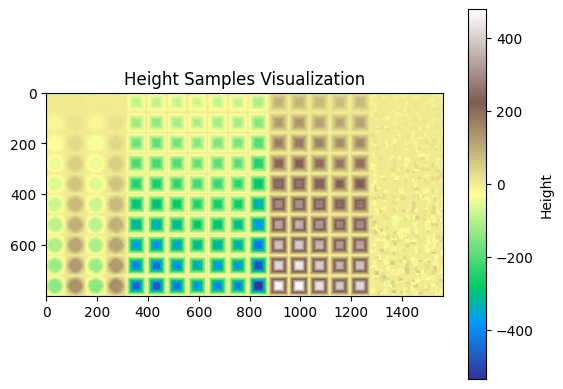

In [21]:
# 读取npy文件
heights = np.load('/home/zhengkr/limx_rl/pointfoot-legged-gym/legged_gym/algorithm/terrain_encoder/terrain.npy')

# 可视化
plt.imshow(heights, cmap='terrain')
plt.colorbar(label='Height')
plt.title('Height Samples Visualization')
plt.show()

In [22]:
@torch.jit.script
def normalize(x, eps: float = 1e-9):
    return x / x.norm(p=2, dim=-1).clamp(min=eps, max=None).unsqueeze(-1)

@torch.jit.script
def quat_apply(a, b):
    shape = b.shape
    a = a.reshape(-1, 4)
    b = b.reshape(-1, 3)
    xyz = a[:, :3]
    t = xyz.cross(b, dim=-1) * 2
    return (b + a[:, 3:] * t + xyz.cross(t, dim=-1)).view(shape)

def quat_apply_yaw(quat, vec):
    quat_yaw = quat.clone().view(-1, 4)
    quat_yaw[:, :2] = 0.0
    quat_yaw = normalize(quat_yaw)
    return quat_apply(quat_yaw, vec)

In [23]:
class BipedCfgPF():

    class env:
        num_envs = 8192
        num_observations = 30  # 更新：移除了相对目标位置，现在obs_buf是30维
        num_critic_observations = 3 + num_observations  # critic还包含3维线性速度
        num_height_samples = 117
        num_actions = 6
        env_spacing = 3.0  # not used with heightfields/trimeshes
        send_timeouts = True  # send time out information to the algorithm
        episode_length_s = 20  # episode length in seconds
        obs_history_length = 10  # number of observations stacked together
        dof_vel_use_pos_diff = True
        fail_to_terminal_time_s = 0.5

    class terrain:
        mesh_type = "trimesh"  # "heightfield" # none, plane, heightfield or trimesh
        horizontal_scale = 0.1  # [m]
        vertical_scale = 0.005  # [m]
        border_size = 25  # [m]
        curriculum = True
        static_friction = 0.4
        dynamic_friction = 0.4
        restitution = 0.8
        # rough terrain only:
        measure_heights = False
        critic_measure_heights = True
        # 64 x 64 measurement grid (covers -3.15m to 3.15m with 0.1m spacing)
        measured_points_x = [round(x, 2) for x in np.linspace(-3.15, 3.15, 64)]
        measured_points_y = [round(y, 2) for y in np.linspace(-3.15, 3.15, 64)]
        selected = False  # select a unique terrain type and pass all arguments
        terrain_kwargs = None  # Dict of arguments for selected terrain
        max_init_terrain_level = 5 + 4  # starting curriculum state
        terrain_length = 8.0
        terrain_width = 8.0
        num_rows = 10  # number of terrain rows (levels)
        num_cols = 20  # number of terrain cols (types)
        # terrain types: [smooth slope, rough slope, stairs up, stairs down, discrete]
        terrain_proportions = [0.1, 0.1, 0.35, 0.25, 0.2]
        # trimesh only:
        slope_treshold = (
            0.75  # slopes above this threshold will be corrected to vertical surfaces
        )

        save_height_samples = True
        height_samples_path = "./terrain.npy"



In [24]:
class TerrainEncoderDataset(Dataset):
    def __init__(self, cfg: BipedCfgPF, device: str = "cuda"):
        self.cfg = cfg
        self.device = device

        # 加载高度图
        self.height_samples = torch.tensor(
            np.load(cfg.terrain.height_samples_path), device=self.device, requires_grad=False
        )  # (H,W)

        # (num_pts,3) 局部坐标 (base 框架)
        self.height_points = self._init_height_points()

        self.rows = len(self.cfg.terrain.measured_points_x)
        self.cols = len(self.cfg.terrain.measured_points_y)

        # 预计算安全采样范围
        H, W = self.height_samples.shape
        hs = self.cfg.terrain.horizontal_scale
        border = self.cfg.terrain.border_size

        local_xy = self.height_points[:, :2]  # (num_pts,2)
        max_r = torch.sqrt((local_xy ** 2).sum(dim=1)).max().item()

        max_x_phys = (H - 2) * hs - border
        max_y_phys = (W - 2) * hs - border
        min_x_phys = -border
        min_y_phys = -border

        self.safe_x_min = min_x_phys + max_r
        self.safe_x_max = max_x_phys - max_r
        self.safe_y_min = min_y_phys + max_r
        self.safe_y_max = max_y_phys - max_r

        if not (self.safe_x_min < self.safe_x_max and self.safe_y_min < self.safe_y_max):
            raise ValueError("地形尺寸过小或测量点分布过大，无法得到有效的安全采样范围。")

    def __len__(self):
        return getattr(self.cfg.terrain, 'dataset_length', 20000)

    def __getitem__(self, idx):
        # 1) 采样 base 平面位置
        base_x = torch.empty(1, device=self.device).uniform_(self.safe_x_min, self.safe_x_max).item()
        base_y = torch.empty(1, device=self.device).uniform_(self.safe_y_min, self.safe_y_max).item()
        base_z = 0.0
        base_pos = torch.tensor([base_x, base_y, base_z], device=self.device)

        # 2) 采样 yaw -> 四元数 (仅 z 轴旋转)
        yaw = torch.empty(1, device=self.device).uniform_(-np.pi, np.pi)
        half = yaw * 0.5
        sin_h = torch.sin(half)
        cos_h = torch.cos(half)
        base_quat = torch.stack([torch.zeros_like(sin_h), torch.zeros_like(sin_h), sin_h, cos_h], dim=-1).squeeze(0)

        # 3) 旋转与平移测量点
        points_world = quat_apply_yaw(base_quat.unsqueeze(0).repeat(self.num_height_points, 1), self.height_points)
        points_world = points_world + base_pos.unsqueeze(0)

        # 4) 映射到高度图索引
        points_xy = points_world[:, :2] + self.cfg.terrain.border_size
        points_xy_idx = (points_xy / self.cfg.terrain.horizontal_scale).long()
        px = torch.clamp(points_xy_idx[:, 0], 0, self.height_samples.shape[0] - 2)
        py = torch.clamp(points_xy_idx[:, 1], 0, self.height_samples.shape[1] - 2)

        # 5) 三点最小值采样
        h1 = self.height_samples[px, py]
        h2 = self.height_samples[px + 1, py]
        h3 = self.height_samples[px, py + 1]
        heights = torch.min(torch.min(h1, h2), h3) * self.cfg.terrain.vertical_scale  # (num_pts,)

        heights_2d = heights.view(self.rows, self.cols)                 # (rows, cols)
        points_world_2d = points_world.view(self.rows, self.cols, 3)    # (rows, cols, 3)
        
        return {
            'base_pos': base_pos,                # (3,)
            'base_quat': base_quat,              # (4,)
            'points_world': points_world_2d,     # (rows, cols, 3)
            'heights': heights_2d               # (rows, cols)
        }

    def _init_height_points(self):
        y = torch.tensor(self.cfg.terrain.measured_points_y, device=self.device, requires_grad=False)
        x = torch.tensor(self.cfg.terrain.measured_points_x, device=self.device, requires_grad=False)
        grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')  # grid_x shape (Nx,Ny)
        self.num_height_points = grid_x.numel()  # Nx*Ny
        pts = torch.zeros(self.num_height_points, 3, device=self.device, requires_grad=False)
        pts[:, 0] = grid_x.flatten()
        pts[:, 1] = grid_y.flatten()
        return pts

In [25]:
dataset = TerrainEncoderDataset(BipedCfgPF(), device='cuda')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Dataset size: {len(dataset)}")
for i, sample in enumerate(dataloader):
    print(f"Batch {i+1}:")
    print(f"Base Position: {sample['base_pos'].shape}")
    print(f"Base Quaternion: {sample['base_quat'].shape}")
    print(f"Points World: {sample['points_world'].shape}")
    print(f"Heights: {sample['heights'].shape}")
    if i == 2:  # 只打印前3个batch
        break

Dataset size: 20000
Batch 1:
Base Position: torch.Size([32, 3])
Base Quaternion: torch.Size([32, 4])
Points World: torch.Size([32, 64, 64, 3])
Heights: torch.Size([32, 64, 64])
Batch 2:
Base Position: torch.Size([32, 3])
Base Quaternion: torch.Size([32, 4])
Points World: torch.Size([32, 64, 64, 3])
Heights: torch.Size([32, 64, 64])
Batch 3:
Base Position: torch.Size([32, 3])
Base Quaternion: torch.Size([32, 4])
Points World: torch.Size([32, 64, 64, 3])
Heights: torch.Size([32, 64, 64])


In [26]:
# 划分训练 / 验证集 (10% 作为验证)
full_length = len(dataset)
val_size = max(1, int(0.1 * full_length))
train_size = full_length - val_size
indices = torch.randperm(full_length).tolist()
val_indices = indices[:val_size]
train_indices = indices[val_size:]
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, drop_last=False)
print(f"Train samples: {len(train_subset)}, Val samples: {len(val_subset)}")

Train samples: 18000, Val samples: 2000


In [27]:
model = SWAE(in_channels=1, latent_dim=64).cuda()

# 形状校验 (eval 模式防止 BN 统计, 且保持 2x2 空间尺寸)
model.eval()
with torch.no_grad():
    dummy = torch.zeros(2, 1, len(BipedCfgPF.terrain.measured_points_x), len(BipedCfgPF.terrain.measured_points_y), device='cuda')  # batch=2
    z = model.encode(dummy)
    print('Encode OK, latent shape:', z.shape)
model.train()

# 训练配置
num_epochs = 500
learning_rate = 5e-3
weight_decay = 1e-5
patience = 30              # 早停耐心
min_delta = 1e-4           # 验证集改进最小幅度
best_val_loss = float('inf')
patience_counter = 0
save_dir = './checkpoints'
os.makedirs(save_dir, exist_ok=True)
ckpt_path = os.path.join(save_dir, 'best_swae.pt')

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# 余弦退火带重启调度器 (每 100 epoch 一次重启)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=100, T_mult=1, eta_min=1e-5)

scaler = torch.cuda.amp.GradScaler(enabled=True)
print(f"Using device: {next(model.parameters()).device}")

Encode OK, latent shape: torch.Size([2, 64])
Using device: cuda:0


/tmp/ipykernel_602887/3309460409.py:27: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)


In [28]:
num_epochs = 100
learning_rate = 5e-3

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(f"Using device: {next(model.parameters()).device}")

# 训练 / 验证 循环（混合精度 + 早停 + 最优模型保存）
train_history = []
val_history = []
loss_values = []  # 兼容之前变量名

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    num_batches = 0
    for batch_idx, batch in enumerate(train_loader):
        img = batch['heights'].to(next(model.parameters()).device).unsqueeze(1)  # (B,1,H,W)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            recon_batch, input_img, z = model(img)
            loss = model.loss_function(recon_batch, input_img, z)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()
        num_batches += 1
    average_train_loss = train_loss / max(1, num_batches)

    # 验证
    model.eval()
    val_loss = 0.0
    val_batches = 0
    with torch.no_grad():
        for batch in val_loader:
            img = batch['heights'].to(next(model.parameters()).device).unsqueeze(1)
            recon_batch, input_img, z = model(img)
            vloss = model.loss_function(recon_batch, input_img, z)
            val_loss += vloss.item()
            val_batches += 1
    average_val_loss = val_loss / max(1, val_batches)

    # 学习率调度更新（放在 epoch 末，使用当前 epoch 内的步长计数）
    scheduler.step(epoch + average_val_loss)  # 以 val loss 微调相位

    train_history.append(average_train_loss)
    val_history.append(average_val_loss)
    loss_values.append(average_train_loss)

    improved = (best_val_loss - average_val_loss) > min_delta
    if improved:
        best_val_loss = average_val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
            'config': {
                'latent_dim': model.latent_dim,
            }
        }, ckpt_path)
        ckpt_tag = ' (saved)'
    else:
        patience_counter += 1
        ckpt_tag = ''

    if (epoch + 1) % 10 == 0 or epoch == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{num_epochs}] LR: {current_lr:.2e} Train: {average_train_loss:.4f} Val: {average_val_loss:.4f}{ckpt_tag}')

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}. Best Val Loss: {best_val_loss:.4f}")
        break

print(f"Best validation loss: {best_val_loss:.4f}. Model saved to {ckpt_path}")

Using device: cuda:0


/tmp/ipykernel_602887/303620405.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


Epoch [1/100] LR: 5.00e-03 Train: 0.3485 Val: 0.2218 (saved)
Epoch [10/100] LR: 5.00e-03 Train: 0.1746 Val: 0.1573
Epoch [20/100] LR: 5.00e-03 Train: 0.1624 Val: 0.1521 (saved)
Epoch [30/100] LR: 5.00e-03 Train: 0.1573 Val: 0.1548
Epoch [40/100] LR: 5.00e-03 Train: 0.1539 Val: 0.1518
Epoch [50/100] LR: 5.00e-03 Train: 0.1517 Val: 0.1493
Epoch [60/100] LR: 5.00e-03 Train: 0.1468 Val: 0.1488
Epoch [70/100] LR: 5.00e-03 Train: 0.1510 Val: 0.1393 (saved)
Epoch [80/100] LR: 5.00e-03 Train: 0.1495 Val: 0.1553
Epoch [90/100] LR: 5.00e-03 Train: 0.1480 Val: 0.1457
Epoch [100/100] LR: 5.00e-03 Train: 0.1476 Val: 0.1456
Best validation loss: 0.1374. Model saved to ./checkpoints/best_swae.pt


/tmp/ipykernel_602887/80119785.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_ckpt = torch.load(ckpt_path)


Loaded best model from epoch 95 with val_loss=0.1374


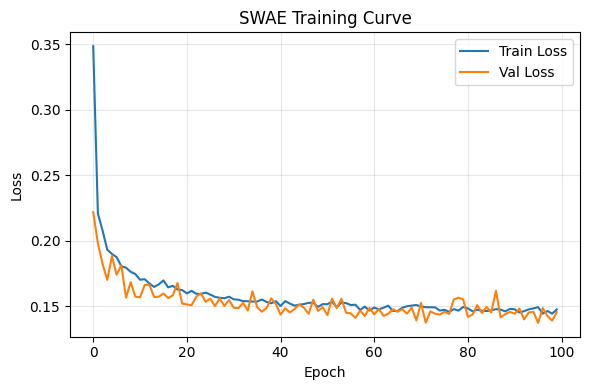

In [30]:
# 加载最佳模型并可视化曲线
best_ckpt = torch.load(ckpt_path)
model.load_state_dict(best_ckpt['model_state_dict'])
print(f"Loaded best model from epoch {best_ckpt['epoch']} with val_loss={best_ckpt['val_loss']:.4f}")

plt.figure(figsize=(6,4))
plt.plot(train_history, label='Train Loss')
plt.plot(val_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SWAE Training Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Latent shape: torch.Size([32, 64]); MSE mean=4.2076e-02, MAE mean=8.8162e-02, Rel MAE mean=2.3014e-01
Saved figure to ./checkpoints/viz/reconstruction_examples.png
Saved figure to ./checkpoints/viz/reconstruction_examples.png


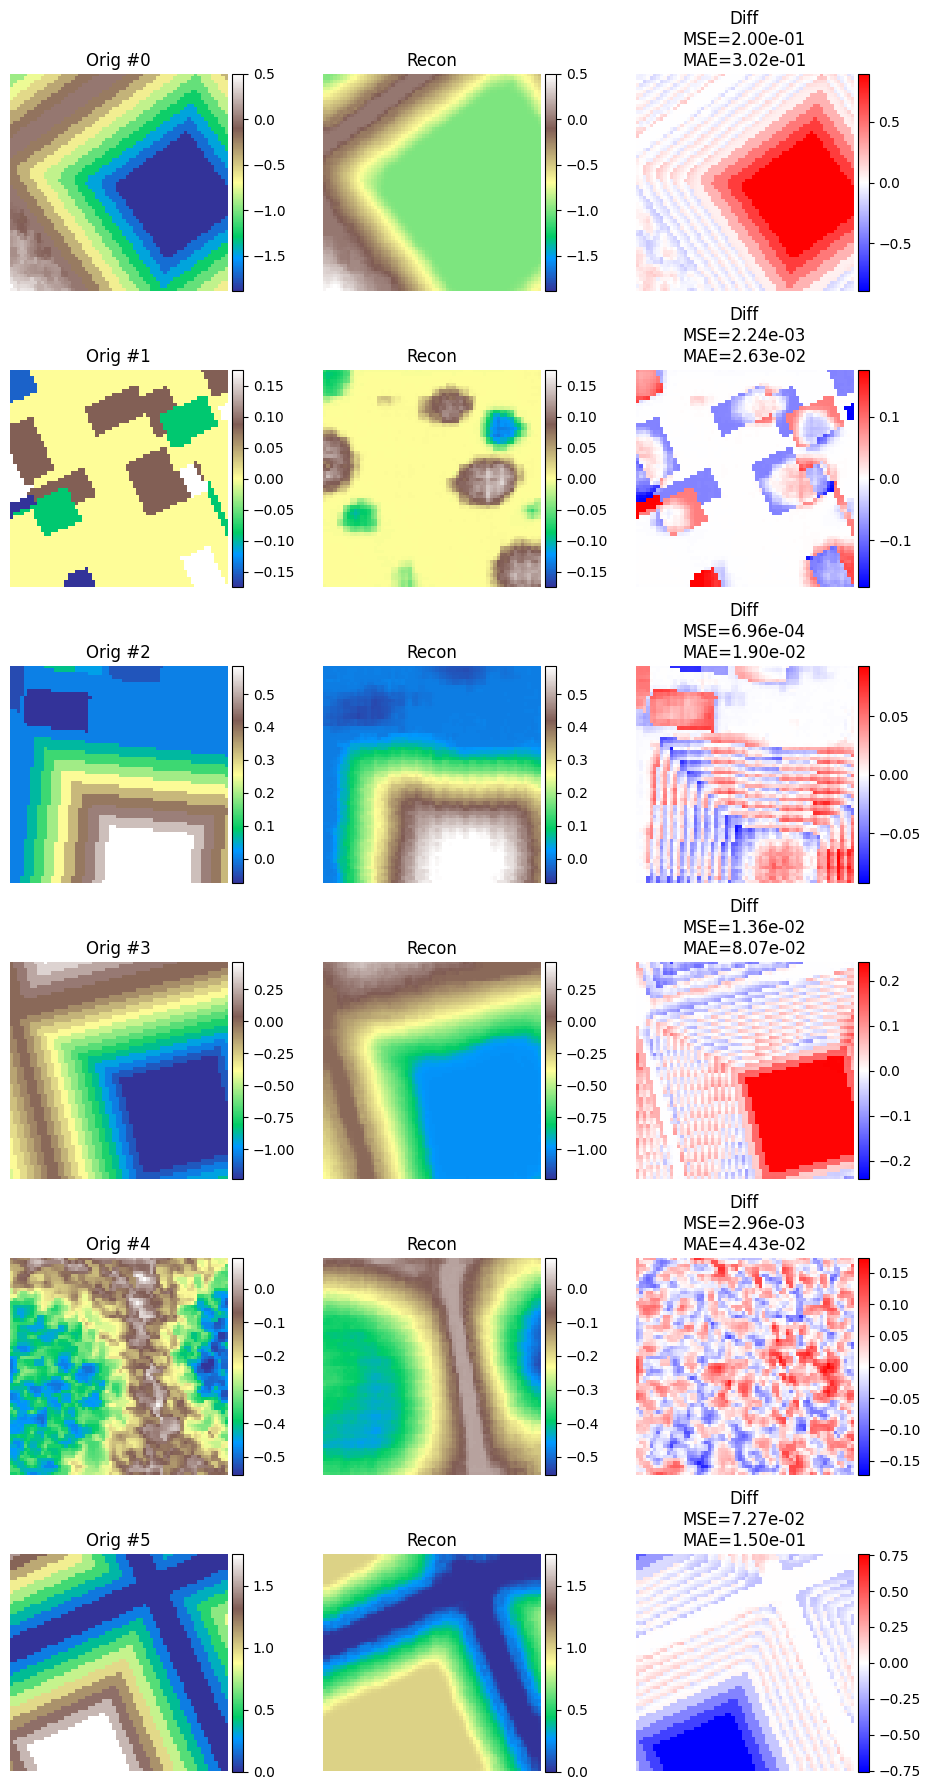

Saved arrays (orig/recon/diff/latent) to ./checkpoints/viz


In [32]:
# 重建可视化: 从验证集中抽样并展示原始/重建/差分
import math

viz_dir = os.path.join(save_dir, 'viz')
os.makedirs(viz_dir, exist_ok=True)

# 若模型尚未加载最优权重，则尝试加载
if not 'best_ckpt' in globals():
    if os.path.isfile(ckpt_path):
        best_ckpt = torch.load(ckpt_path, map_location=next(model.parameters()).device)
        model.load_state_dict(best_ckpt['model_state_dict'])
        print(f"Loaded best checkpoint (epoch {best_ckpt['epoch']}, val_loss={best_ckpt['val_loss']:.4f})")
    else:
        print('Checkpoint not found, using current model weights.')

model.eval()

@torch.no_grad()
def visualize_reconstruction(num_show: int = 6, save: bool = True):
    # 取一个验证 batch
    batch = next(iter(val_loader))
    imgs = batch['heights'].to(next(model.parameters()).device)          # (B,H,W)
    imgs_in = imgs.unsqueeze(1)                                          # (B,1,H,W)
    recons, _, z = model(imgs_in)
    recons = recons.squeeze(1)                                           # (B,H,W)

    # 指标
    mse = ((recons - imgs) ** 2).mean(dim=(1,2))
    mae = (recons - imgs).abs().mean(dim=(1,2))
    eps = 1e-8
    rel_mae = mae / (imgs.abs().mean(dim=(1,2)) + eps)

    print(f"Latent shape: {z.shape}; MSE mean={mse.mean():.4e}, MAE mean={mae.mean():.4e}, Rel MAE mean={rel_mae.mean():.4e}")

    n = min(num_show, imgs.shape[0])
    cols = 3
    fig, axes = plt.subplots(n, cols, figsize=(cols*3.2, n*3.0))
    if n == 1:
        axes = axes.reshape(1, cols)
    for i in range(n):
        orig = imgs[i].detach().cpu().numpy()
        recon = recons[i].detach().cpu().numpy()
        diff = recon - orig
        vmin = orig.min(); vmax = orig.max()
        dv = max(abs(diff.min()), abs(diff.max())) + 1e-9
        im0 = axes[i,0].imshow(orig, cmap='terrain', vmin=vmin, vmax=vmax)
        axes[i,0].set_title(f'Orig #{i}')
        plt.colorbar(im0, ax=axes[i,0], fraction=0.046, pad=0.02)
        im1 = axes[i,1].imshow(recon, cmap='terrain', vmin=vmin, vmax=vmax)
        axes[i,1].set_title('Recon')
        plt.colorbar(im1, ax=axes[i,1], fraction=0.046, pad=0.02)
        im2 = axes[i,2].imshow(diff, cmap='bwr', vmin=-dv, vmax=dv)
        axes[i,2].set_title(f'Diff\nMSE={mse[i]:.2e}\nMAE={mae[i]:.2e}')
        plt.colorbar(im2, ax=axes[i,2], fraction=0.046, pad=0.02)
        for c in range(cols):
            axes[i,c].axis('off')
    plt.tight_layout()
    if save:
        out_path = os.path.join(viz_dir, 'reconstruction_examples.png')
        plt.savefig(out_path, dpi=150)
        print('Saved figure to', out_path)
    plt.show()

    if save:
        np.save(os.path.join(viz_dir, 'orig.npy'), imgs[:n].cpu().numpy())
        np.save(os.path.join(viz_dir, 'recon.npy'), recons[:n].cpu().numpy())
        np.save(os.path.join(viz_dir, 'diff.npy'), (recons - imgs)[:n].cpu().numpy())
        np.save(os.path.join(viz_dir, 'latent.npy'), z[:n].cpu().numpy())
        print('Saved arrays (orig/recon/diff/latent) to', viz_dir)

visualize_reconstruction(num_show=6, save=True)

model.train();  # 如果后续还要继续训练